# 2. Double Deep Q-Learning for Navigation
---

In the notebook [Deep Q-Learning for Navigation](https://nbviewer.jupyter.org/github/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/01-Deep-Q-Learning-for-Navigation.ipynb) I solved the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector), using [Deep Q-Learning](https://arxiv.org/pdf/1509.06461.pdf). In 
this notebook I will give a second solution using [Doube Deep Q-Learning](https://arxiv.org/pdf/1509.06461.pdf). See the [README](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/README.md) for instructions on how to setup your environment to run the code here.  

In Q-learning and deep Q-learning, the max operator in the loss function uses the same values to both select and evaluate an action. 
This can lead to over optimistic value estimates.  **Double deep Q-learning** mitigates this problem by using a different target:

$$ y^{DDQN}=R_t+\gamma\cdot Q(S_{t+1},  \operatorname{arg\,max}_{a'} Q(S_{t+1}, a'|\theta)|\theta^-).$$

Implementing this change requires only a minor tweak to the learn method of the agent we defined in the previous notebook which I've saved in a python [module](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/dqn_agent.py) so I can subclass it and override the learn method as below.  

In [1]:
from dqn_agent import Agent, TAU

class DoubleQAgent(Agent):
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get predicted actions for next states from local model
        next_actions = self.qnetwork_local(next_states).detach().argmax(1).unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).gather(1, next_actions)

        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)


        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     



Since training for double deep Q-learning is the same as that for deep Q-learning, I won't repeat that code in this notebook but just import it from the
[trainer.py module](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/trainer.py) where I've saved it earlier.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.22
Episode 200	Average Score: 2.56
Episode 300	Average Score: 7.68
Episode 400	Average Score: 10.49
Episode 500	Average Score: 12.77
Episode 531	Average Score: 13.06
Environment solved in 431 episodes!	Average Score: 13.06


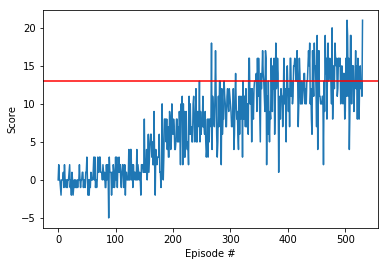

CPU times: user 4min 4s, sys: 26.6 s, total: 4min 31s
Wall time: 8min 50s


In [2]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline  

import torch.nn.functional as F
from trainer import train
from unityagents import UnityEnvironment


env = UnityEnvironment(file_name="./data/Banana.app")
agent = DoubleQAgent(state_size=37, action_size=4, seed=0)
scores = train(env, agent)

Again the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) was solved in under 431 episodes. I'm not really seeing an improvement over simple Deep Q-Learning.  Maybe this environment is too simple to demonstrate that? There does seem to be less variance in this plot so maybe Double Deep Q-Learning is doing better than vanilla Deep Q-Learning on this task, after all. 

I'll save the weights of the local network of this successful agent to the file double-dqn-model-weights.pth.

In [5]:
import torch
torch.save(agent.qnetwork_local.state_dict(), 'double-dqn-model-weights.pth')